In [3]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader

from utils import Missingness
from utils import knn_impute_image, mean_impute_image
from utils import load_mnist
from utils import run_dec_pipeline
from utils import plot_dec_performance

from models import Autoencoder, DEC
from utils import train_autoencoder, train_dec


In [5]:
input_dim = 784
latent_dim = 10
n_clusters = 10
learning_rate = 0.01

N_FEATURES = 784
LATENT_DIM = 10
N_CLUSTERS = 10
BATCH_SIZE = 256

K_KNN = 5
AE_EPOCHS = 25
DEC_EPOCHS = 50
num_rows_list = np.arange(0, 20, 2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

H_W = 28

ari_scores = []
nmi_scores = []

# Loading data

In [6]:
train_dataset, test_data = load_mnist()

# We flatten to (N, 784) and scale to [0, 1]
data = train_dataset.data.float() / 255.0
data = data.view(-1, 784)

labels = train_dataset.targets.numpy()
tensor_x = data.to(device)

# Create dataset with indices to map each batch to a full P distribution
# This allows us to compute P globally but train in batches
indices = torch.arange(len(tensor_x)).to(device)
dataset = TensorDataset(tensor_x, indices)
train_loader = DataLoader(dataset, batch_size=256, shuffle=True)

In [7]:
indices = torch.arange(len(tensor_x)).to(device)
full_dataset = TensorDataset(tensor_x, indices)
full_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=False)

missingness = Missingness()

# Imputing mean

In [8]:
ari_scores_knn = []
nmi_scores_knn = []

In [9]:
for num_rows in num_rows_list:
    print(f"\n-------- Missingness rows {num_rows} --------")

    X_missing_flat, _ = missingness.apply_corruption(
        tensor_x,
        corruption_type='row_missing',
        num_rows=num_rows
    )

    X_missing_image = X_missing_flat.view(-1, 1, H_W, H_W)

    X_imputed_image = knn_impute_image(X_missing_image, k=K_KNN)
    X_imputed_flat = X_imputed_image.view(-1, N_FEATURES)

    ari, nmi = run_dec_pipeline(
        X_imputed_flat,
        labels,
        indices,
        device=device,
        ae_epochs=20,
        dec_epochs=75,
        n_clusters=10,
        latent_dim=10,
        n_features=784,
    )

    ari_scores_knn.append(ari)
    nmi_scores_knn.append(nmi)

    print(f"\n RESULTS ({num_rows} MCAR): ARI={ari:.4f} | NMI={nmi:.4f}")


-------- Missingness rows 0 --------
Autoencoder training
Epoch 10/20: average loss = 0.0132
Epoch 20/20: average loss = 0.0106
DEC training
Epoch 10/75: average loss = 0.1520
Epoch 20/75: average loss = 0.1199
Epoch 30/75: average loss = 0.1010
Epoch 40/75: average loss = 0.0880
Epoch 50/75: average loss = 0.0782
Epoch 60/75: average loss = 0.0707
Epoch 70/75: average loss = 0.0647
Epoch 75/75: average loss = 0.0621

 RESULTS (0% MCAR): ARI=0.6860 | NMI=0.7677

-------- Missingness rows 2 --------
Autoencoder training
Epoch 10/20: average loss = 0.0125
Epoch 20/20: average loss = 0.0101
DEC training
Epoch 10/75: average loss = 0.1619
Epoch 20/75: average loss = 0.1256
Epoch 30/75: average loss = 0.1047
Epoch 40/75: average loss = 0.0907
Epoch 50/75: average loss = 0.0804
Epoch 60/75: average loss = 0.0725
Epoch 70/75: average loss = 0.0663
Epoch 75/75: average loss = 0.0637

 RESULTS (2% MCAR): ARI=0.7598 | NMI=0.8137

-------- Missingness rows 4 --------
Autoencoder training
Epoch 1

In [10]:
results_df = pd.DataFrame({
    'Missingness': missingness_percentages,
    'ARI': ari_scores_knn,
    'NMI': nmi_scores_knn
})

print(results_df)

   Missingness       ARI       NMI
0            0  0.686023  0.767740
1           10  0.759808  0.813714
2           20  0.721942  0.785992
3           30  0.659127  0.745240
4           40  0.720182  0.789322
5           50  0.701225  0.781790
6           60  0.641019  0.729942
7           70  0.476642  0.598455
8           80  0.665101  0.724088
9           90  0.489378  0.580387


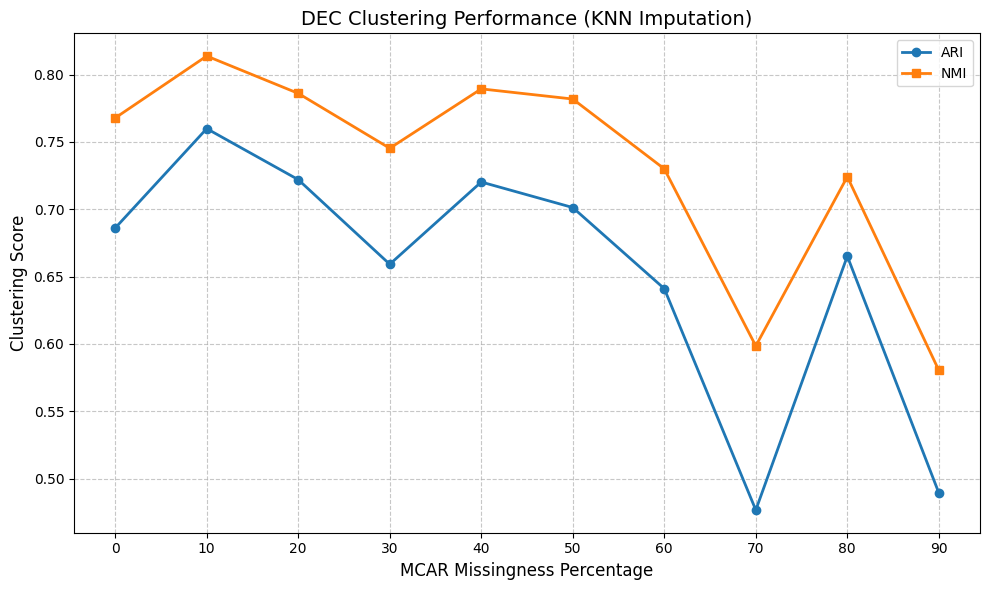

In [12]:
plot_dec_performance(
    missingness_percentages=missingness_percentages,
    score_arrays=[ari_scores_knn, nmi_scores_knn],
    labels=['ARI', 'NMI'],
    title='DEC Clustering Performance (KNN Imputation)'
)

# Mean imputation

In [13]:
ari_scores_mean = []
nmi_scores_mean = []

In [14]:
for mcar_percent in missingness_percentages:
    missing_rate_float = mcar_percent / 100.0
    print(f"\n--- Testing Missingness {mcar_percent}% ---")

    X_missing_flat, _ = missingness.apply_corruption(
        tensor_x,
        corruption_type='mcar',
        missing_rate=missing_rate_float
    )

    X_missing_image = X_missing_flat.view(-1, 1, H_W, H_W)
    X_imputed_image = mean_impute_image(X_missing_image)
    X_imputed_flat = X_imputed_image.view(-1, N_FEATURES)

    ari, nmi = run_dec_pipeline(
        X_imputed_flat,
        labels,
        indices,
        device=device,
        ae_epochs=20,
        dec_epochs=75,
        n_clusters=10,
        latent_dim=10,
        n_features=784,
    )

    ari_scores_mean.append(ari)
    nmi_scores_mean.append(nmi)

    print(f"\nPercentage ({mcar_percent}% MCAR): ARI={ari:.4f} | NMI={nmi:.4f}")


--- Testing Missingness 0% ---
Autoencoder training
Epoch 50/75: average loss = 0.0802
Epoch 60/75: average loss = 0.0723
Epoch 70/75: average loss = 0.0660
Epoch 75/75: average loss = 0.0633

Percentage (0% MCAR): ARI=0.7456 | NMI=0.8031

--- Testing Missingness 10% ---
Autoencoder training
Epoch 10/20: average loss = 0.0191
Epoch 20/20: average loss = 0.0170
DEC training
Epoch 10/75: average loss = 0.1741
Epoch 20/75: average loss = 0.1319
Epoch 30/75: average loss = 0.1086
Epoch 40/75: average loss = 0.0930
Epoch 50/75: average loss = 0.0816
Epoch 60/75: average loss = 0.0731
Epoch 70/75: average loss = 0.0665
Epoch 75/75: average loss = 0.0637

Percentage (10% MCAR): ARI=0.6549 | NMI=0.7387

--- Testing Missingness 20% ---
Autoencoder training
Epoch 10/20: average loss = 0.0236
Epoch 20/20: average loss = 0.0219
DEC training
Epoch 10/75: average loss = 0.1921
Epoch 20/75: average loss = 0.1401
Epoch 30/75: average loss = 0.1135
Epoch 40/75: average loss = 0.0961
Epoch 50/75: avera

In [15]:
results_df = pd.DataFrame({
    'Missingness': missingness_percentages,
    'ARI (Mean-DEC)': ari_scores_mean,
    'NMI (Mean-DEC)': nmi_scores_mean
})

print(results_df)

   Missingness  ARI (Mean-DEC)  NMI (Mean-DEC)
0            0        0.745586        0.803129
1           10        0.654921        0.738684
2           20        0.635775        0.722686
3           30        0.549419        0.652046
4           40        0.464997        0.596348
5           50        0.066106        0.097916
6           60        0.046635        0.084489
7           70        0.046298        0.081072
8           80        0.040821        0.073579
9           90        0.032311        0.057981


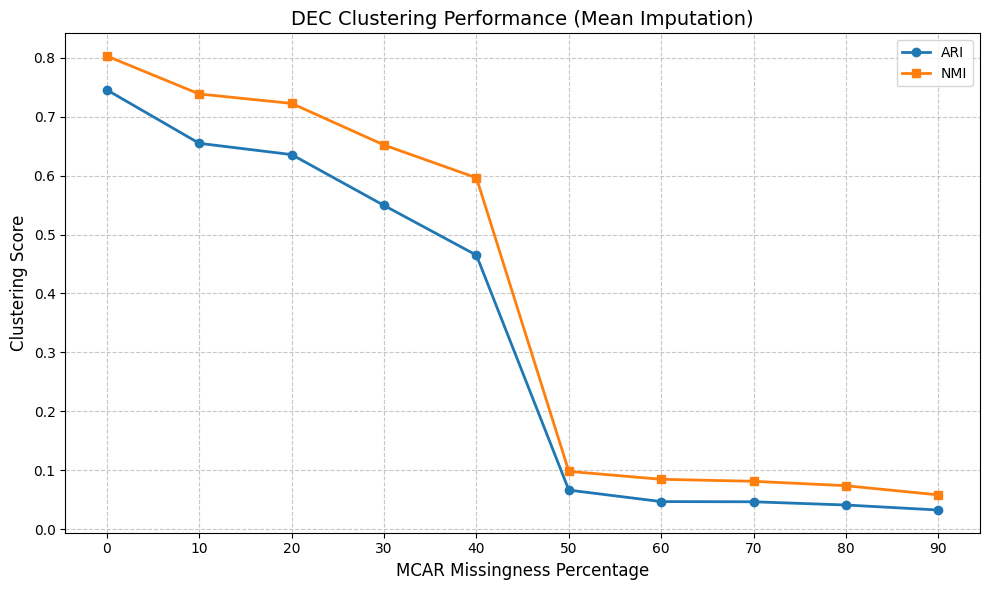

In [16]:
plot_dec_performance(
    missingness_percentages=missingness_percentages,
    score_arrays=[ari_scores_mean, nmi_scores_mean],
    labels=['ARI', 'NMI'],
    title='DEC Clustering Performance (Mean Imputation)'
)

# Denoising Autoencoder